In [5]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(font_scale=1.3, style='darkgrid', palette='Set2')

WARNING    /Users/aleks311001/mambaforge/envs/neuro/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
 [py.warnings]
WARNING    /Users/aleks311001/mambaforge/envs/neuro/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
 [py.warnings]


In [40]:
import gym
import brian2 as b2
from enum import Enum
from collections import defaultdict
import copy

from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, module='.*brian2.*')
filterwarnings(action='ignore', category=UserWarning, 
               message='.*WARN: We recommend you to use a symmetric and normalized Box action space.*')

In [7]:
class JointNeurons:
    def __init__(self, TAU_U=0.285, TAU_V=0.302, u_init=(0.7, 0.9), W=-2.120, t_step=10*b2.ms):
        # u1 - F, u2 - E
        
        assert(len(u_init) == 2)
        b2.start_scope()

        eqs = '''
        du1/dt = (u0 - u1 - w * clip(u2, 0, inf) - b * v1 + z1 + f1) / tau : 1
        du2/dt = (u0 - u2 - w * clip(u1, 0, inf) - b * v2 + z2 + f2) / tau : 1
        dv1/dt = (-v1 + clip(u1, 0, inf)) / tau_v : 1
        dv2/dt = (-v2 + clip(u2, 0, inf)) / tau_v : 1
        u0 : 1
        w : 1
        b : 1
        z1 : 1
        z2 : 1
        f1 : 1
        f2 : 1
        tau : second
        tau_v : second
        '''
        U0 = 0.805

        self.joint = b2.NeuronGroup(1, model=eqs, method='euler')
        self.joint.u0 = U0
        self.joint.w = W
        self.joint.b = 3.078
        self.joint.tau = TAU_U * b2.second
        self.joint.tau_v = TAU_V * b2.second
        self.joint.u1 = u_init[0]
        self.joint.u2 = u_init[1]
        self.joint.v1 = 0.0
        self.joint.v2 = 0.0

        self.t_step = t_step
        self.u_mon = b2.StateMonitor(self.joint, ['u1', 'u2'], record=True)
        self.net = b2.Network(self.joint, self.u_mon)

    def get_y(self):
        y1 = max(0, self.joint.u1[0])
        y2 = max(0, self.joint.u2[0])
        return y1, y2
    
    def step(self, z, f=(0, 0)):
        self.joint.z1 = z[0]
        self.joint.z2 = z[1]
        self.joint.f1 = f[0]
        self.joint.f2 = f[1]

        self.net.run(self.t_step)
    
        y1, y2 = self.get_y()
        return y1 - y2

In [32]:
class Joint(Enum):
    HIP = 'Hip'
    KNEE = 'Knee'

class Side(Enum):
    LEFT = 'Left'
    RIGHT = 'Right'

class Controller:
    # 1 - left, 2 - right
    
    def __init__(self, w=None, a1=0.124, a2=0.770, t_step=1*b2.ms):
        if w is None:
            w = [-0.607, 0.0, 0.0, -0.311, -1.649, 0.0, -1.934, 0.0]
        assert(len(w) == 8)
        self.w = w

        self.a1, self.a2 = a1, a2
        
        tau = {
            'u': {Joint.HIP: 0.285, Joint.KNEE: 0.143},
            'v': {Joint.HIP: 0.302, Joint.KNEE: 0.151},
        }
        
        u_init = {s: {j: np.random.uniform(0.5, 1, 2) for j in Joint} for s in Side}
        
        self.joints = {
            s: {j: JointNeurons(TAU_U=tau['u'][j], TAU_V=tau['v'][j], u_init=u_init[s][j], t_step=t_step)
                for j in Joint} 
            for s in Side
        }
        
        self.f = {s: {j: 0.0 for j in Joint} for s in Side}
        self.z = {s: {j: (0.0, 0.0) for j in Joint} for s in Side}

    def update_z(self):
        y = {s: {j: self.joints[s][j].get_y() for j in Joint} for s in Side}
        
        for s in Side:
            for op_s in Side:
                if op_s != s:
                    break
                    
            self.z[s][Joint.HIP] = (
                self.w[0] * y[op_s][Joint.HIP][0] + self.w[1] * y[op_s][Joint.HIP][1], 
                self.w[2] * y[op_s][Joint.HIP][0] + self.w[3] * y[op_s][Joint.HIP][1],
            )
            self.z[s][Joint.KNEE] = (
                self.w[4] * y[s][Joint.HIP][0] + self.w[5] * y[s][Joint.HIP][1], 
                self.w[6] * y[s][Joint.HIP][0] + self.w[7] * y[s][Joint.HIP][1],
            )
            
    def update_f(self, y):
        t_r, t_l = 0.0, 0.0
        # theta2 - theta3
        self.f[Side.RIGHT][Joint.HIP] += self.a1 * (y[Side.LEFT][Joint.HIP] - 
                                                    y[Side.RIGHT][Joint.HIP] + t_l)
        self.f[Side.LEFT][Joint.HIP] += self.a1 * (y[Side.RIGHT][Joint.HIP] - 
                                                   y[Side.LEFT][Joint.HIP] + t_r)
        self.f[Side.RIGHT][Joint.KNEE] += self.a2 * (t_l) * (y[Side.RIGHT][Joint.HIP] + 
                                                               y[Side.RIGHT][Joint.KNEE])
        self.f[Side.LEFT][Joint.KNEE] += self.a2 * (t_r) * (y[Side.LEFT][Joint.HIP] + 
                                                              y[Side.LEFT][Joint.KNEE])   
    
    def update_f_obs(self, obs):
        t_l, t_r = obs[8], obs[13]
        theta = [-obs[0], np.pi - obs[4], np.pi - obs[9], -(obs[6] - 1), -(obs[11] - 1)]
        
        self.f[Side.RIGHT][Joint.HIP] = self.a1 * (theta[1] - theta[2] + t_l)
        self.f[Side.LEFT][Joint.HIP] = self.a1 * (theta[2] - theta[1] + t_r)
        self.f[Side.RIGHT][Joint.KNEE] = self.a2 * t_l * (theta[0] + theta[2] + theta[4] - np.pi)
        self.f[Side.LEFT][Joint.KNEE] = self.a2 * t_r * (theta[0] + theta[1] + theta[3] - np.pi)
    
    def step(self, observation=None):
        self.update_z()
        
        y = {s: {j: self.joints[s][j].step(z=self.z[s][j], f=(self.f[s][j], -self.f[s][j]))
                 for j in Joint} for s in Side}
        
#         self.update_f(y)
        if observation is not None:
            self.update_f_obs(observation)
        else:
            self.update_f(y)
        
        return y

In [39]:
c_stab = Controller(t_step=10 * b2.ms)
# wait stabilisation
for i in tqdm(range(500)):
    c_stab.step()

  0%|          | 0/500 [00:00<?, ?it/s]

In [42]:
env = gym.make('BipedalWalker-v3')
c = copy.copy(c_stab)
observation = env.reset()

for _ in range(500):
    y = c.step(observation)
    action = np.array([y[Side.LEFT][Joint.HIP], y[Side.LEFT][Joint.KNEE], 
                       y[Side.RIGHT][Joint.HIP], y[Side.RIGHT][Joint.KNEE]]) * 5.5
    action = np.clip(action, -1, 1)
    print(action)
    observation, reward, done, info = env.step(action)
    env.render()
    
env.close()

[ 0.31131719  0.20126364  0.         -0.02956084]
[0.33021638 0.         0.         0.01994902]
[0.34761403 0.         0.         0.29354819]
[0.31781912 0.         0.         0.21880253]
[0.33923547 0.         0.         0.15710526]
[0.35845978 0.         0.         0.10676505]
[0.37644075 0.         0.         0.06622591]
[0.39317263 0.         0.         0.03407257]
[0.36330872 0.         0.         0.00903094]
[ 0.33701788  0.          0.         -0.01003507]
[ 0.31392486  0.          0.         -0.02412935]
[ 0.29369885  0.          0.         -0.0341313 ]
[ 0.27339272  0.          0.         -0.04080465]
[ 0.25293918  0.          0.         -0.04480713]
[ 0.23227661  0.          0.         -0.04670021]
[ 0.21137532  0.          0.         -0.046959  ]
[ 0.19028678  0.          0.         -0.04598174]
[ 0.16917445  0.          0.         -0.0440989 ]
[ 0.14953301  0.          0.         -0.04158171]
[0.17615181 0.         0.         0.44978366]
[0.20027053 0.         0.         0.

[ 0.48305572  0.          0.         -0.19308265]
[ 0.45215613  0.          0.         -0.17659574]
[ 0.42151186  0.          0.         -0.15978409]
[ 0.39312838  0.          0.         -0.1431477 ]
[ 0.36726039  0.          0.         -0.12705837]
[ 0.34370492  0.          0.         -0.11178217]
[ 0.32219311  0.          0.         -0.09749901]
[ 0.30259795  0.          0.         -0.08431944]
[ 0.284686    0.          0.         -0.07229912]
[ 0.26853713  0.          0.         -0.06145098]
[ 0.25409193  0.          0.         -0.05175548]
[ 0.2417657   0.          0.         -0.04316919]
[ 0.22810541  0.          0.         -0.03563172]
[ 0.21611438  0.          0.         -0.02907146]
[ 0.20447554  0.          0.         -0.02341017]
[ 0.19314217  0.          0.         -0.01856651]
[ 0.17975639  0.          0.         -0.01445891]
[ 0.16464034  0.          0.         -0.01100761]
[ 0.14810641  0.          0.         -0.00813623]
[ 0.13047635  0.          0.         -0.00577282]


[ 0.34490376  0.          0.         -0.02936331]
[ 0.31682325  0.          0.         -0.02610224]
[ 0.28834144  0.          0.         -0.02299726]
[ 0.25953667  0.          0.         -0.02008722]
[ 0.23154563  0.          0.         -0.01739645]
[ 0.20437254  0.          0.         -0.01493783]
[ 0.17801433  0.          0.         -0.01271523]
[ 0.15246119  0.          0.         -0.01072566]
[ 0.12770656  0.          0.         -0.00896109]
[ 0.10374853  0.          0.         -0.00740982]
[ 0.08058923  0.          0.         -0.00605777]
[ 0.05823479  0.          0.         -0.00488933]
[ 0.03669518  0.          0.         -0.00388821]
[ 0.01598401  0.          0.         -0.00303796]
[-0.00388145  0.          0.         -0.00232243]
[-0.02288058  0.          0.         -0.00172613]
[-0.04101794  0.          0.         -0.0012344 ]
[-0.05842277  0.          0.         -0.00083364]
[-0.07533069  0.          0.         -0.00051131]
[-0.09146406  0.          0.         -0.00025603]


In [ ]:
c = Controller(t_step=10 * b2.ms)
y = []

for i in tqdm(range(2500)):
    y.append(c.step())

(-0.15, 0.1)

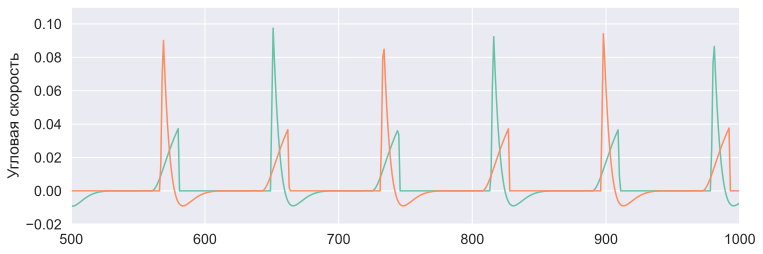

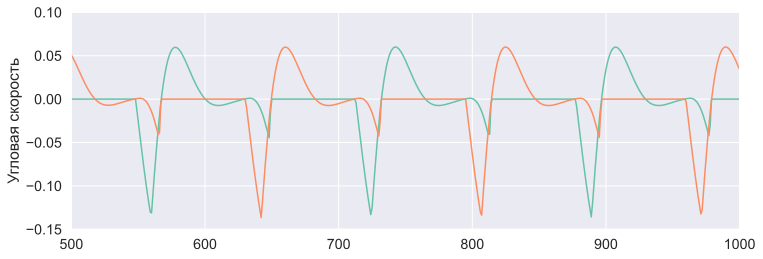

In [227]:
plt.figure(figsize=(12, 4))
plt.ylabel('Угловая скорость')
plt.plot([item[Side.LEFT][Joint.KNEE] for item in y])
plt.plot([item[Side.RIGHT][Joint.KNEE] for item in y])
plt.xlim((500, 1000))
plt.ylim((-0.02, 0.11))

plt.figure(figsize=(12, 4))
plt.ylabel('Угловая скорость')
plt.plot([item[Side.LEFT][Joint.HIP] for item in y])
plt.plot([item[Side.RIGHT][Joint.HIP] for item in y])
plt.xlim((500, 1000))
plt.ylim((-0.15, 0.1))

In [19]:
3.1415/2/12

0.13089583333333335

In [209]:
env = gym.make('BipedalWalker-v3')
observation, info = env.reset(return_info=True)
env.close()
observation

array([ 2.7469294e-03,  3.8572994e-06, -5.0294318e-04, -1.6000025e-02,
        9.2274010e-02,  1.1675444e-03,  8.6002433e-01,  4.7491616e-04,
        1.0000000e+00,  3.2646772e-02,  1.1675123e-03,  8.5364592e-01,
       -7.9444546e-04,  1.0000000e+00,  4.4081366e-01,  4.4581977e-01,
        4.6142241e-01,  4.8954979e-01,  5.3410238e-01,  6.0246056e-01,
        7.0914829e-01,  8.8593107e-01,  1.0000000e+00,  1.0000000e+00],
      dtype=float32)

In [29]:
env = gym.make('BipedalWalker-v3')
observation = env.reset()

action = -np.ones(4)*0
for _ in range(25):
    observation, reward, done, info = env.step(action)
    env.render()

# env.close()
observation[6] - 1, observation[11] - 1

(-1.628363847732544, -1.628308653831482)

In [23]:
observation

array([ 5.6711727e-01,  1.0262185e-01,  4.5723513e-02, -1.5414758e-01,
       -3.3321053e-01, -9.9999988e-01, -5.9574342e-01,  0.0000000e+00,
        0.0000000e+00, -4.4650742e-01, -1.0000001e+00, -6.3490796e-01,
       -1.9868216e-08,  0.0000000e+00,  4.0791789e-01,  4.1255042e-01,
        4.2698872e-01,  4.5301709e-01,  4.9424490e-01,  5.5750185e-01,
        6.5622807e-01,  8.1981838e-01,  1.0000000e+00,  1.0000000e+00],
      dtype=float32)

In [ ]:
np.pi / 0.6246

In [ ]:
class CPG(b2.Network):
    def __init__(self, *):
        eqs_cpg = '''
        dv/dt = (u0 - u1 - w*y2 - b*v) / tau : 1
        dv_th/dt = (v_th_0 - v_th) / tau_th : 1
        v_rest : 1
        tau : second
        tau_th : second
        v_th_0 : 1
        v_reset : 1
        theta : 1
        '''

        threshold_cpg = 'v > v_th'

        reset_cpg = '''
        v = v_reset
        v_th += theta
        '''

        CPG = b2.NeuronGroup(4, model=eqs_cpg, threshold=threshold_cpg, 
                             reset=reset_cpg, method='exact')

        CPG.tau = TAU
        CPG.tau_th = TAU_TH
        CPG.v = [3/3, 0/3, 2/3, 1/3]
        CPG.v_rest = V_REST
        CPG.v_reset = V_RESET
        CPG.v_th_0 = V_TH_0
        CPG.theta = THETA
#         CPG.w_syn = -1
        CPG.v_th = CPG.v_rest

        S_CPG = b2.Synapses(CPG, model='w_syn : 1', on_pre='v_post += w_syn')
#         S_CPG.connect(i=[0, 1, 1, 2, 2, 3], j=[1, 0, 2, 1, 3, 2])
#         S_CPG.connect(condition='i==j')
        S_CPG.connect(i=[1, 1, 2, 2], j=[0, 2, 1, 3])
        S_CPG.w_syn = W_SYN

        self.s_mon = b2.SpikeMonitor(CPG)
        self.v_mon = b2.StateMonitor(CPG, ["v", "v_th"], record=True)
        b2.Network.__init__(self, CPG, S_CPG, self.s_mon, self.v_mon)
        
        self.names = ['Knee left', 'Hip left', 'Hip right', 'Knee right']
        
    def plot_v_spikes(self, t_bounds=None, idxs=None, figsize=(12,10)):
        if idxs is None:
            idxs = list(range(len(self.v_mon.v)))
#         if t_bounds is None:
#             t_bounds = (min(self.v_mon.t/b2.ms), max(self.v_mon.t/b2.ms))

        plt.figure(figsize=figsize)

        ax1 = plt.subplot(2, 1, 1)
        for i, (v, name) in enumerate(zip(self.v_mon.v, self.names)):
            plt.plot(self.v_mon.t/b2.ms, v, c=f'C{i}', label=name)
        for i, t in zip(self.s_mon.i, self.s_mon.t):
            plt.axvline(t/b2.ms, c=f'C{i}', ls='--', alpha=0.3, lw=1)
        if t_bounds:
            plt.xlim(t_bounds)

        plt.xlabel('Time (ms)')
        plt.ylabel('v')
        plt.legend()

        plt.subplot(2, 1, 2, sharex=ax1)
        plt.plot(self.s_mon.t/b2.ms, np.array(self.s_mon.i), '.k')
        for i, t in zip(self.s_mon.i, self.s_mon.t):
            plt.axvline(t/b2.ms, c=f'C{i}', ls='--', alpha=0.3, lw=1)
        if t_bounds:
            plt.xlim(t_bounds)
        plt.xlabel('Time (ms)')
        plt.ylabel('Neuron num')

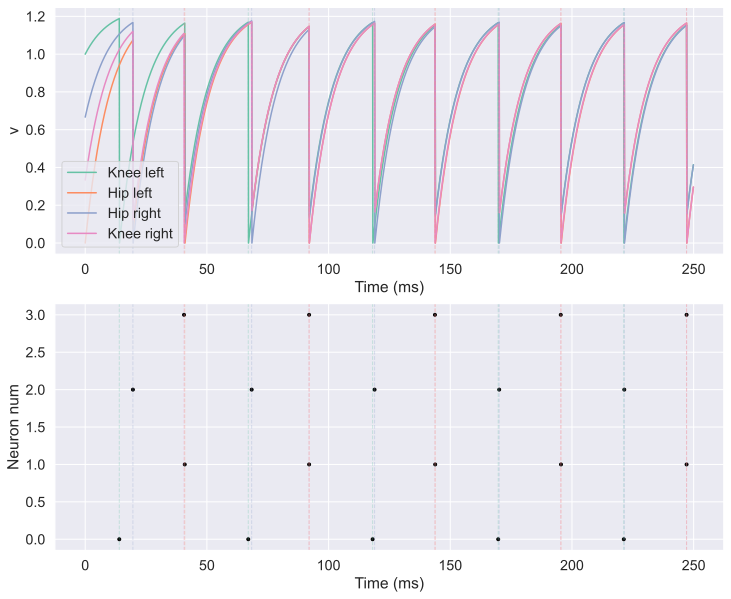

In [95]:
cpg = CPG(W_SYN=-1, V_REST=1.25)
cpg.run(250 * b2.ms)
cpg.plot_v_spikes()